In [1]:
from GPAdversarialBound import getshiftbounds, getpred
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# GP Adversarial Bound Demo

We consider a very simple 2d example with four datapoints, on four corners of a 1x1 square. Three of the points are 1, while one point (at [1,1]) is -1:

```
   1|1         -1
    |
    |   
    |
   0|1__________1
     0          1
```
We set the lengthscale to 1 and the the value of $\sigma^2$ is currently fixed in the code to 1.0.

The kernel is an RBF kernel (this is a necessary aspect of the current mathematical derivation).

In [2]:
l = 1.0
X = np.array([[0,0],[0,1],[1,0],[1,1]])*1.0
Y = np.array([[1,1,1,-1]]).T*1.0

#positive Y:
pos_allshifts,pos_dbinfo = getshiftbounds(X,Y,l=l,totalits=300)
print(pos_allshifts)
#negative Y:
neg_allshifts,neg_dbinfo = getshiftbounds(X,-Y,l=l,totalits=300)
print(neg_allshifts)

stopped at iteration 299
stopped at iteration 299
[0, 0]
stopped at iteration 299
stopped at iteration 299
[0.54818099318820313, 0.55758113390489561]


### Interpretation

We have first asked for an upper bound on the greatest increase in the prediction over the two dimensions. Because the gradient is basically never positive in the 0 to 1 domain, the algorithm has found an upper bound of zero.

The story is very different if we include, for example the region from -1 to 1. In this case there is considerable positive gradient available from -1 (as the predictions climb from the prior mean towards the positive training data), similarly if we include the domain from 1 to 2, there's positive gradient as the predictions return to the prior from the negative sample, at [1,1].

By inverting Y, we can perform the same analysis for the decrease in the prediction (with respect to the training inputs).

To help see things more clearly let's plot the predictions:

I've plotted points that are greater than 0.6 or less than 0.

/home/mike/anaconda3/lib/python3.6/site-packages/matplotlib/collections.py:836: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


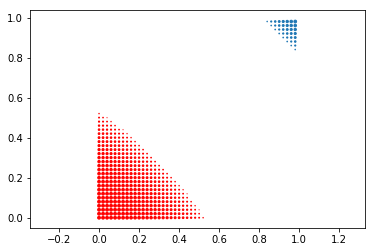

In [3]:
Xtest = []
for x1 in np.arange(0,1,0.02):
    for x2 in np.arange(0,1,0.02):
        Xtest.append([x1,x2])
Xtest = np.array(Xtest)
preds = getpred(Xtest,X,Y,l)
plt.scatter(Xtest[:,0],Xtest[:,1],-100*preds,label='<0.0')
plt.scatter(Xtest[:,0],Xtest[:,1],-60+100*preds,c='r',label='>0.6')
plt.axis('equal');

This simply shows how the predictions vary over the domain. As one can see the gradient is negative for both inputs.

Let's see how much the predictions change for these test points. As the problem is symmetrical I'll just consider one axis.

Here I'm plotting the data - but all on the same graph, effectively each line is for one value of input 0, showing the predictions as input 1 changes. The lower lines are for when input 0 is near 1 (where the negative training point lies) and the right hand side of the plot is near one (bringing us closer to the negative training point).

Text(0.5,1,'Predictions')

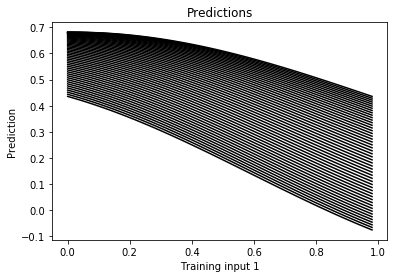

In [4]:
plt.plot(np.arange(0,1,0.02),np.reshape(preds,[50,50]),'k-');
plt.xlabel('Training input 1')
plt.ylabel('Prediction')
plt.title('Predictions')

The biggest change for any of these 'slices' we can find the approximate value of:

In [5]:
np.max(np.max(np.reshape(preds,[50,50]),0)-np.min(np.reshape(preds,[50,50]),0))

0.51058772000662833

Our upper bound above was 0.55758 which is greater than this empirical value (phew!).

### What does this mean practically?

Our bound means that we can only change the prediction by up to 0.56 by changing one of the inputs.

If we want to move from a very positive value, of 0.6, to the smallest value in the domain of about 0. We would need to change both training points. As 0.6>0.56.

One can see this in the earlier 2d plot: To get from the region greater than 0.6, to the region of less than 0 can't be done by changing just one input.

### Detour: Current Debug Concern...

Given the problem is symmetric for the two input dimensions; I'm worried why the two bounds are different for the two dimensions. I think this indicates there might be a programming error. We need to find where this asymmetry arises.


### 4d example

In [23]:
l = 1.0
X = np.array([[0,1,1,0],[0,0,1,0],[1,0,0,1],[1,0,1,0],[1,0,1,1],[0,1,0,0]])*1.0
Y = np.array([[1,1,-1,-1,-1,1]]).T*1.0

#positive Y:
pos_allshifts,pos_dbinfo = getshiftbounds(X,Y,l=l,totalits=300)
print(pos_allshifts)
#negative Y:
neg_allshifts,neg_dbinfo = getshiftbounds(X,-Y,l=l,totalits=300)
print(neg_allshifts)

stopped at iteration 1
stopped at iteration 299
stopped at iteration 299
stopped at iteration 299
[0, 0.72539187691728824, 0.29549385091034081, 0]
stopped at iteration 299
stopped at iteration 299
stopped at iteration 299
stopped at iteration 299
[1.0121906652843407, 0, 0.29549385091034086, 0.73099206442463815]


In [25]:
getpred(X,X,Y,l)

array([[ 0.62925353],
       [ 0.38893927],
       [-0.58530706],
       [-0.38893927],
       [-0.62925353],
       [ 0.58530706]])

## MNIST example

We demonstrate the tool with a more complex example, the MNIST dataset.

In [27]:
from mnist import MNIST
#download the mnist data from http://yann.lecun.com/exdb/mnist/
#save in mnistdata folder in same directory as this notebook

def getMNISTexample(scalingfactor=7):
    mndata = MNIST('./mnistdata')
    mnist_training = mndata.load_training()

    #B = [np.array([[-10.0,20.0],[-10.0,20.0]])]
    bigX = np.array(mnist_training[0])[np.array(mnist_training[1])<2,:]
    bigXtest = bigX[91:100,:]
    bigX = bigX[0:90,:]
    Y = np.array(mnist_training[1])[np.array(mnist_training[1])<2]
    Y = Y[:,None]*2.0-1.0
    Ytest = Y[91:100,:]
    Y = Y[0:90,:]

    def scale(X,res):
        newX = []
        for x in X:
            newx = np.zeros([1+int(28/res),1+int(28/res)])
            xreshaped = x.reshape(28,28)
            for newi,i in enumerate(np.arange(0,28,res)):
                for newj,j in enumerate(np.arange(0,28,res)):
                    newx[newi,newj] = np.mean(xreshaped[i:(i+res),j:(j+res)])
            newX.append(newx.reshape(newx.size))
        return np.array(newX)

    X = scale(bigX,scalingfactor)
    Xtest = scale(bigXtest,scalingfactor)
    newres = int(X[0,:].size**.5)
    return X,Y,Xtest,Ytest

X,Y,Xtest,Ytest = getMNISTexample(scalingfactor=5)
#positive Y:
l = 1000.0
#pos_allshifts,pos_dbinfo = getshiftbounds(X,Y,l=l,totalits=50,valmax=255)
print(pos_allshifts)
#negative Y:
#neg_allshifts,neg_dbinfo = getshiftbounds(X,-Y,l=l,totalits=50,valmax=255)
print(neg_allshifts)

[0, 0.72539187691728824, 0.29549385091034081, 0]
[1.0121906652843407, 0, 0.29549385091034086, 0.73099206442463815]


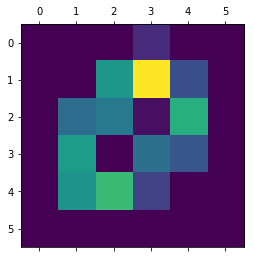

In [28]:
plt.matshow(np.reshape(X[0,:],[6,6]))

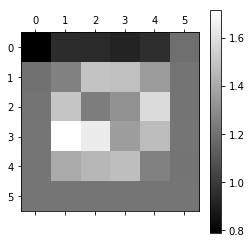

In [22]:
plt.matshow(np.reshape(np.max(np.c_[neg_allshifts,pos_allshifts],1),[6,6]),cmap='gray')
plt.colorbar()

In [13]:
preds = getpred(Xtest,X,Y,l)
np.max(preds)-np.min(preds)

2.1034030206538787

## Bruteforce

[[ 0.73760977]]
[-0.08265836]


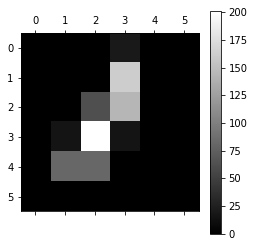

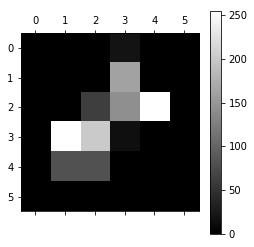

In [34]:
confident = np.argmax((getpred(X,X,Y,l)))
advX = X[confident:(confident+1),:].copy() #the initial test point we're going to use...
plt.matshow(advX.reshape(6,6),cmap='gray')
plt.colorbar()
print(getpred(advX,X,Y,l))
N = 36
adv = advX.copy()
for it in range(1):
    adv = adv.repeat(N,0)
    for i in range(N):
        adv[i::N,i]=255
        
lowest = np.Inf
lowestim = None
for it in range(len(adv)):
    b = adv[it,:][None,:]
    for it in range(1):
        b = b.repeat(N,0)
        for i in range(N):
            b[i::N,i]=255
    preds = getpred(b,X,Y,l)
    minpredi = np.argmin(preds)
    if (preds[minpredi]<lowest):
        lowest = preds[minpredi]
        lowestim = b[minpredi]        
        
print(lowest)
plt.matshow(lowestim.reshape(6,6),cmap='gray')
plt.colorbar()